# STEP 0. 작업환경 구성하기

```
! pip install imageio
! pip install Pillow
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


데이터셋이 이미 tf.keras에 들어가 있기 때문에 꺼내기만 하면 되고  
그런데 분류문제가 아니기 때문에 라벨이 필요가 없다  
언더바로 라벨 데이터를 무시하겠음

# STEP 1. 데이터셋 구성하기

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
train_x.shape

(50000, 32, 32, 3)

In [7]:
test_x.shape

(10000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


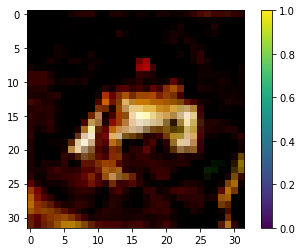

In [8]:
# 데이터 확인하기  
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

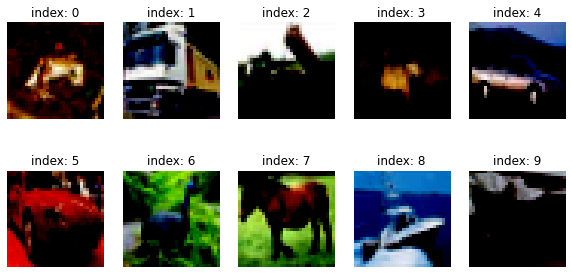

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

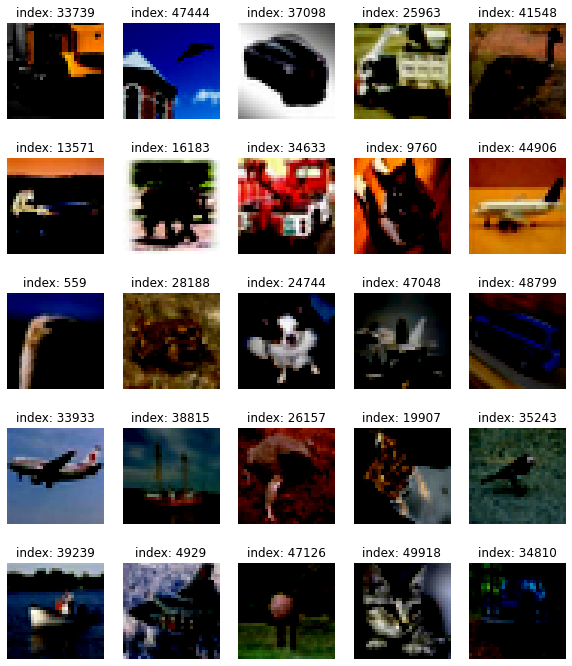

In [9]:
# random으로 추출
plt.figure(figsize=(10, 12))

for i in range(25):
    # [[my CODE]]
    rand = np.random.randint(50000)
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[rand].reshape(32, 32, 3))
    plt.title(f'index: {rand}')
    plt.axis('off')

plt.show()

# STEP 2. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.   
- noise = tf.random.normal(\[1, 100\])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.  
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.  

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*768, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 768))) # 256*3=768

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128*3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64*3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

make_generator_model이라는 함수를 만들어서 언제든 생성자를 생성할 수 있도록  
  
**함수 내부**  
* tf.keras.Sequential()로 모델을 시작한 후 레이어를 차곡차곡 쌓아줌    
* Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층  
* 세 번의 Conv2DTranspose 층을 이용해 (8, 8, 768) → (16, 16, 192) → (32, 32, 3) 순으로 이미지를 키워나간다  
* 여기서 최종 사이즈인 (28, 28, 1)은 우리가 준비했던 데이터셋과 형상이 동일  
* BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화  
* 중간층들의 활성화 함수는 모두 LeakyReLU를 사용  
* 마지막 층에는 활성화 함수로 tanh를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함  
  
**생성자의 입력 벡터는 어떤 형태입니까?**
>모델은 입력값으로 (batch_size, 100) 형상의 노이즈 벡터를 받습니다.  
  


**처음 입력된 벡터는 어떤 레이어를 지나며, 첫 레이어를 지난 후의 shape는 어떤 형태입니까?**  
>(batch_size, 100) 벡터 -> 7 x 7 x 256 = 12544개의 노드를 가진 첫 번째 Dense 레이어 -> (batch_size, 12544) 형상의 벡터  
  
  

**첫 번째 레이어를 지난 후 벡터는 어떤 층을 지나게 됩니까? 이 레이어는 왜 필요합니까?**  
>Reshape layer  
차원 벡터를 (7, 7, 256) 형상의 3차원 벡터로 변환하기 위해서  
  


In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 49152)             4915200   
_________________________________________________________________
batch_normalization (BatchNo (None, 49152)             196608    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 49152)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 768)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 384)         7372800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 384)         1536      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 384)         0

## noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.

In [14]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.7405911 , -2.7729046 , -1.7631555 ,  0.6685635 , -0.13764858,
        -0.05655495, -0.07255523, -0.11733664,  0.71005136,  1.7580688 ,
         0.28448015,  0.01039546,  1.0380002 ,  0.26757723, -1.6582376 ,
         1.703798  ,  0.40813866,  1.2920189 ,  0.01038028, -0.45972896,
        -1.0496731 ,  1.0440489 ,  1.8990377 , -1.1533594 ,  1.131732  ,
         1.3583742 , -1.0240281 , -0.03276499, -0.2594763 ,  1.4027096 ,
         0.7545531 ,  1.2549448 ,  0.14930156, -0.24460752,  1.3163631 ,
        -0.69323075,  0.3191731 ,  0.68154824, -1.0701935 ,  0.43290716,
         0.39210236, -0.38145286, -0.41596085,  1.4181397 ,  0.9626058 ,
         0.8177457 ,  0.5331849 ,  0.95567584,  0.01205078, -0.02021637,
        -0.17459929,  0.05061396,  0.5885474 , -0.16621527,  0.79156864,
         0.268933  , -0.54563755,  0.298099  ,  1.5287945 , -0.48062682,
         2.0810626 , -2.8855171 , -0.96492136, -0.93021977, -0.6953799 ,
 

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

## 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

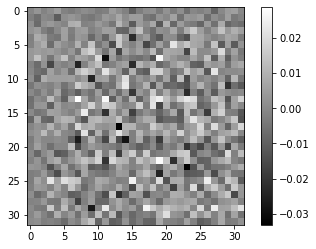

In [16]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

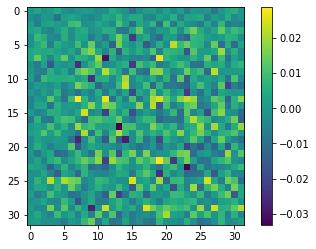

In [17]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

#  STEP 3. 판별자 모델 구현하기

- 32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.  
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

## (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.

In [18]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(192, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(768, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

판별자도 함수로 구현함  

**함수 내부**  
* 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다  
  첫 번째 Conv2D 층에서 입력된 \[28, 28, 1\] 사이즈의 이미지는 다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)까지  
* Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환  
* 마지막 Dense Layer를 거쳐 단 하나의 값을 출력

In [19]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 192)       14592     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 192)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 192)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 768)         3687168   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 768)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 768)         0         
_________________________________________________________________
flatten (Flatten)            (None, 49152)            

## 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [20]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-5.1598297e-05]], dtype=float32)>

# STEP 4. 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.  
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.  
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다. 

## 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**생성자 손실함수**  

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**판별자 손실함수**

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.

In [24]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

예를 들어 위의 코드를 설명  
ex.) real_output = tf.Tensor(\[0.2, 0.4, 0.7, 0.9]) 라면,

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
> tf.Tensor([False, False, True, True])

(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
> tf.Tensor([0.0, 0.0, 1.0, 1.0])

(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
> 0.5


## 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 샘플 확인

In [26]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# STEP 5. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.  
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.  
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.  
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.  

## 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.

In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train_step 함수를 하나하나 뜯어보면 다음과 같습니다.

>(1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음  
(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함  
(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기  
(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성    
(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력    
(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산  
(7) accuracy 계산 : fake_output, real_output으로 discriminator가  
(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산  
(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신   
(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴  

## 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.

In [28]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

## 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

## training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 6. 학습 과정 진행하기

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.  
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.  
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.  

여기서 epoch을 추가 진행할때 위에서 checkpoint 모듈을 이용해 모델을 저장해놨는데  
학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있다  
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시

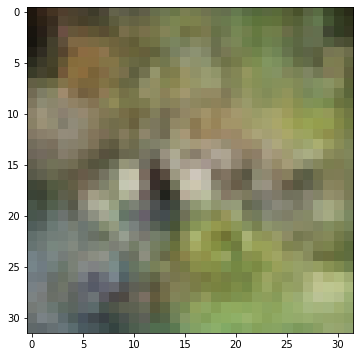

In [31]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [32]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [33]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.  

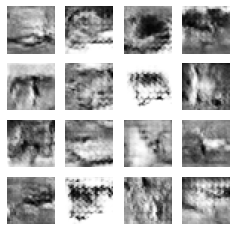

Time for training : 3560 sec


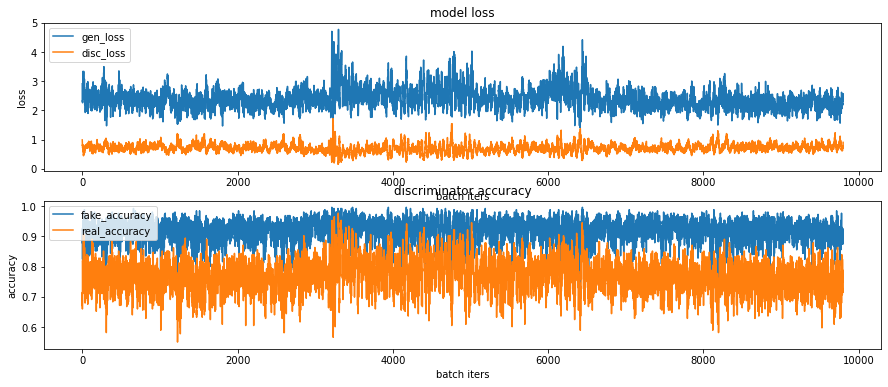

CPU times: user 58min 43s, sys: 32.8 s, total: 59min 16s
Wall time: 59min 21s


In [34]:
%%time
train(train_dataset, EPOCHS, save_every)
# 21:45~22:41

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.

In [35]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_10_dcgan.gif

-rw-r--r-- 1 aiffel-dj35 aiffel-dj35 2164830  3월  2 09:59 /home/aiffel-dj35/aiffel/dcgan_newimage/cifar10/cifar_10_dcgan.gif


# STEP 7. (optional) GAN 훈련 과정 개선하기

## 컬러로 바꾸기
- 6.2단계 수정 : 흑백으로 나왔다 -> 컬러로 바꾸자  
참고 : https://colab.research.google.com/drive/1NWUrPJLLVvA-THpv2XqEgYeemuFl3Qj-#scrollTo=RmdVsmvhPxyy

In [36]:
predictions

NameError: name 'predictions' is not defined

In [ ]:
predictions[i]

In [ ]:
predictions.shape

In [37]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
#         plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.imshow(predictions[i] * 0.5 + 0.5) # rgb로 바꾸기 위해 변경
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [38]:
save_every = 5
EPOCHS = 5

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

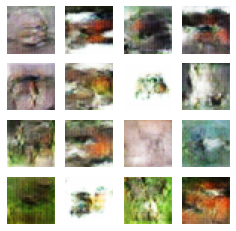

Time for training : 346 sec


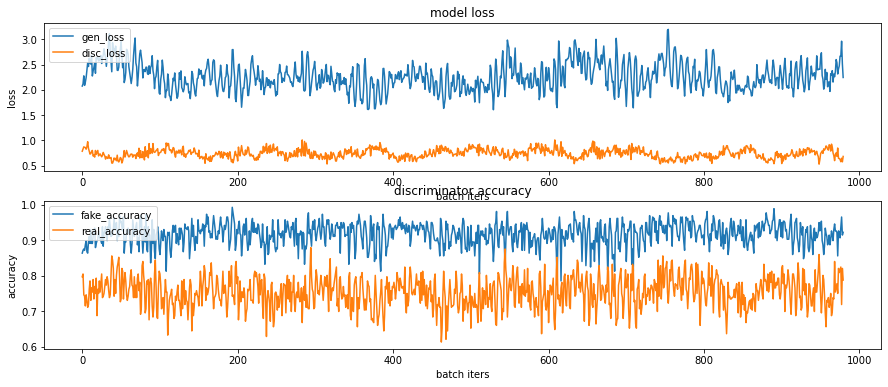

CPU times: user 5min 44s, sys: 2.48 s, total: 5min 47s
Wall time: 5min 47s


In [39]:
%%time
train(train_dataset, EPOCHS, save_every)
# 22:44~22:49

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [42]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_10_dcgan_epoch_55.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar_10_dcgan_epoch_55.gif

-rw-r--r-- 1 aiffel-dj35 aiffel-dj35 2155074  3월  2 10:49 /home/aiffel-dj35/aiffel/dcgan_newimage/cifar10/cifar_10_dcgan_epoch_55.gif


## 모델 수정

In [1]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

NameError: name 'tf' is not defined

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)
# 22:44~22:49

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.